### Importing Libraries

In [1]:
# import sys
# import math
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
# import statsmodels.formula.api as smf

# from scipy.stats import ttest_1samp
# from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline
# # pd.options.display.float_format = '{:.6f}'.format

### Importing Data

In [2]:
data = pd.read_csv("sgemm_product.csv")
data.head()

MWG  NWG  KWG  MDIMC  NDIMC  MDIMA  NDIMB  KWI  VWM  VWN  STRM  STRN  SA  \
0   16   16   16      8      8      8      8    2    1    1     0     0   0   
1   16   16   16      8      8      8      8    2    1    1     0     0   0   
2   16   16   16      8      8      8      8    2    1    1     0     0   1   
3   16   16   16      8      8      8      8    2    1    1     0     0   1   
4   16   16   16      8      8      8      8    2    1    1     0     1   0   

   SB  Run1 (ms)  Run2 (ms)  Run3 (ms)  Run4 (ms)  
0   0     115.26     115.87     118.55     115.80  
1   1      78.13      78.25      79.25      79.19  
2   0      79.84      80.69      80.76      80.97  
3   1      84.32      89.90      86.75      85.58  
4   0     115.13     121.98     122.73     114.81

Adding a field 'Runtime' - which is our final dependent variable for linear regression

In [3]:
data['Runtime'] = data[['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']].sum(axis = 1)/4

In [4]:
data.head()

MWG  NWG  KWG  MDIMC  NDIMC  MDIMA  NDIMB  KWI  VWM  VWN  STRM  STRN  SA  \
0   16   16   16      8      8      8      8    2    1    1     0     0   0   
1   16   16   16      8      8      8      8    2    1    1     0     0   0   
2   16   16   16      8      8      8      8    2    1    1     0     0   1   
3   16   16   16      8      8      8      8    2    1    1     0     0   1   
4   16   16   16      8      8      8      8    2    1    1     0     1   0   

   SB  Run1 (ms)  Run2 (ms)  Run3 (ms)  Run4 (ms)   Runtime  
0   0     115.26     115.87     118.55     115.80  116.3700  
1   1      78.13      78.25      79.25      79.19   78.7050  
2   0      79.84      80.69      80.76      80.97   80.5650  
3   1      84.32      89.90      86.75      85.58   86.6375  
4   0     115.13     121.98     122.73     114.81  118.6625

### EDA

In [5]:
# Check for NAs
print('NA values count: \n{}'.format(data.isnull().sum().sum()))

NA values count: 
0


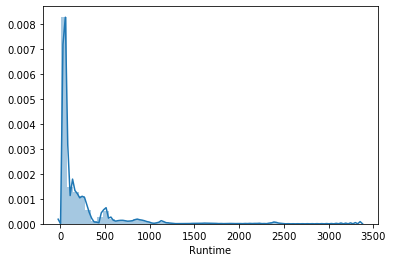

In [6]:
#Distribution of dependent variable
sns.distplot(data['Runtime']);

The distribution is heavily skewed towards the right. We will try to bring the skew back to that of a normal distribution by taking the log of the variable. We will further normalize the data by using MinMaxScaler from the sklearn library, which uses the following transformations:
<center>X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 
<center>X_scaled = X_std * (max - min) + min

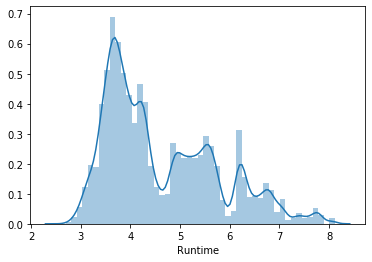

In [7]:
data['Runtime'] = data[['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']].sum(axis = 1)/4
data['Runtime'] = np.log(data['Runtime'])

#Distribution of dependent variable
sns.distplot(data['Runtime']);

As can be seen, we were able to lose some of the skewness from our variable owing to the log transformation. 

Next, we will be splitting our data into a train and a test set before we normalize it. Normalization has to be done <b>after</b> the train test split to avoid data leakage.

In [8]:
x_train ,x_test ,y_train , y_test = train_test_split(
    data.drop(columns = ['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)','Runtime']), 
    data[['Runtime']], test_size=0.3,  random_state=100)

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

Normalizing data

In [9]:
scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_train = sm.add_constant(x_train)
x_test = scaler.transform(x_test)
x_test = sm.add_constant(x_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

Next, some eda

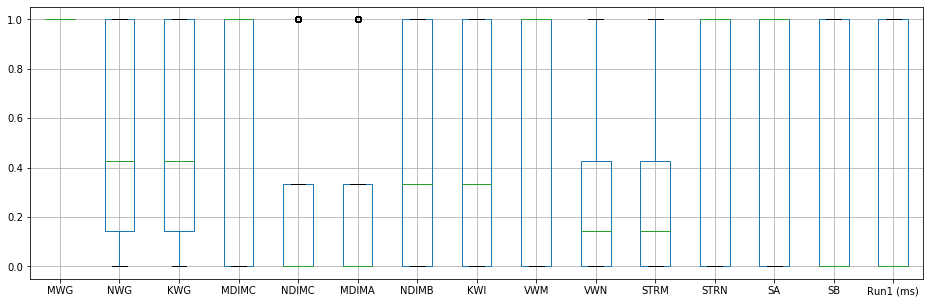

In [10]:
pd.DataFrame(x_train, columns = data.columns[:15]).boxplot(grid='True', figsize = [16,5]);

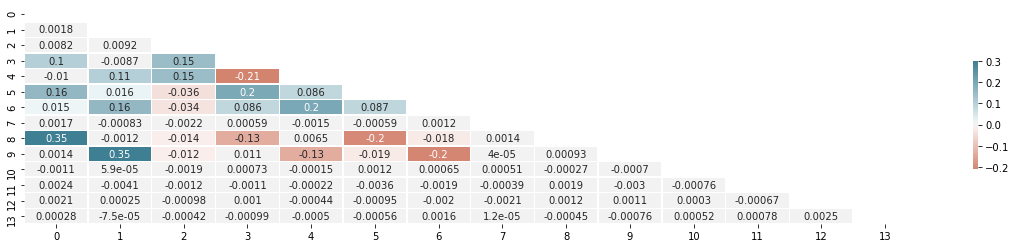

In [11]:
corr = pd.DataFrame(x_train[:,1:]).corr()
cmap = sns.diverging_palette(20, 220, n=200)#sns.diverging_palette(220, 10, as_cmap=True) #color set
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 4))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": .5} , annot = True);


There are no significant correlations among the variables. Also the lack of outliers allows us to smoothly move forward with building our model.

### Defining functions for Linear Regression

#### #1. Calculate slope of the cost function

In [12]:
def calc_m_lin(m, alpha, x, y, length):
    return (m - alpha*(x.T @ (x @ m - y))/length)

#### #2. Calculate value of the cost function

In [13]:
def calc_cost_lin(m, x, y, length):
    return sum((x @ m - y)**2)/(2*length)

#### #3. Setting up the gradient descent algorithm

In [14]:
def grad_desc_lin(x, y, length, m, alpha, iters, costs, threshold = 0):
    
    for i in range(0,iters):
        cost = calc_cost_lin(m, x, y, length)[0]
        costs.append(cost)
        m = calc_m_lin(m, alpha, x, y, length)
        if i > 1 and (costs[len(costs) - 2] - costs[len(costs) - 1] <= threshold):
            break
    return [m, costs, i]

### #4. Function to print model outputs

In [15]:
def model_parameters(coeff, x, y, names):
    
    err = np.subtract(y, x@coeff)
    #Calculating R2 = 1 - sse/sst
    sse = np.sum(err**2)
    sst = np.sum((y - np.mean(y, axis = 0))**2) 
    r2 = 1 - (sse/sst)
    
    #Calculating Adj R2 = 1 - (1 - r2)*(n - 1)/(n - k - 1)
    adj_r2 = 1 - (1 - r2)*(len(x) - 1)/(len(x) - len(coeff) - 1)
    
    #variable name, coeff, p val, t - stat, std errors
    model_output = pd.DataFrame(columns = ['Variable', 'Coeff', 'Std Err', 'T- Val'])
    df = len(x) - len(coeff) - 1
    x_terms = np.sum(np.subtract(x, np.mean(x, axis = 0))**2, axis = 0)
    for i in range(0, len(coeff)):
        se = math.sqrt(sse/df)/math.sqrt(x_terms[i] + sys.float_info.epsilon)
        t  =coeff[i]/se
        model_output.loc[i] = [names[i], coeff[i][0], se, t[0]]
    print('Model Output:\n')
    print(model_output)
    print('\n')
    
    #Mean Absolute Error
    mae = np.sum(abs(err))/len(x)
    
    #Mean Squared Error
    mse = np.sum(err**2)/len(x)
    
    #Mean Absolute Percentage Error
    mape = 100 * np.sum(abs(1-err/y))/len(x)
    
    #Root Mean Squared Error
    rmse = math.sqrt(np.sum(err**2)/len(x))
    print("R2 of the estimated model: {}".format(r2))
    print("Adjusted R2 of the estimated model: {}".format(adj_r2))
    print('Mean Absolute Error: {}'.format(mae))
    print('Mean Squared Error: {}'.format(mse))
    print("Mean Absolute Percentage Error: {}%".format(mape))
    print("Root Mean Squared Error: {}".format(rmse))

### Fitting the model

Fitting the model for an initial alpha of 0.015, with 3500 iterations and not checking for any thresholds in the drop of costs

In [16]:
np.random.seed(0)
x_train = x_train
y_train = np.array(y_train).reshape(-1,1)
m = np.random.rand(x_train.shape[1],1)
alpha = 0.015
iters = 3500

In [17]:
betas = grad_desc_lin(x_train, y_train, len(x_train), m, alpha, iters, [])

In [18]:
names = ['const'] + list(data.columns)
model_parameters(betas[0], x_train, y_train, names)
plt.plot(betas[1])
print('*'*60)
print('Final cost: {}\n'.format(betas[1][-1]))

NameError: name 'math' is not defined

Comparing with OLS regressor from the Statsmodels liibrary

In [ ]:
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

As we can see, the coefficients from both the models are close to each other. The difference can be attributed to . We have not implemented L1 and L2 norm regularization for our models yet, and that is what we will do in the upcoming sections.

Comparing our models to the OLS regressor from the statsmodel library:

In [ ]:
length = len(x_test)

y_hat_ols = model.predict(x_test)
err_ols = y_test.squeeze()-y_hat_ols

mae_ols = np.sum(np.absolute(err_ols))/length
mse_ols = np.sum(err_ols**2)/length
mape_ols = 100 * np.sum(np.absolute(1-err_ols/y_test.squeeze()))/length
rmse_ols = np.sqrt(np.sum(err_ols**2)/length)

y_hat_func = x_test@betas[0]
err_func = y_test-y_hat_func

mae_func = np.sum(np.absolute(err_func))/length
mse_func = np.sum(err_func**2)/length
mape_func = 100 * np.sum(np.absolute(1-err_func/y_test))/length
rmse_func = np.sqrt(np.sum(err_func**2)/length)

print('Mean Absolute Error: \nOLS: {:.5f}; Function: {:.5f}; Function - OLS: {:.5f}\n'.format(mae_ols, mae_func, -mae_ols+mae_func))
print('Mean Squared Error: \nOLS: {:.5f}; Function: {:.5f}; Function - OLS: {:.5f}\n'.format(mse_ols, mse_func, -mse_ols+mse_func))
print("Mean Absolute Percentage Error: \nOLS: {:.5f}; Function: {:.5f}; Function - OLS: {:.5f}\n".format(mape_ols, mape_func, -mape_ols+mape_func))
print("Root Mean Squared Error: \nOLS: {:.5f}; Function: {:.5f}; Function - OLS: {:.5f}\n".format(rmse_ols, rmse_func, -rmse_ols+rmse_func))

### Implementing L1 and L2 norms for Linear regression

To implement L1 and L2 norms, we just need to modify our cost function. We will add L1 and L2 weights to our cost function, leaving the other calculations intact.

In [ ]:
def calc_m_lin(m, alpha, x, y, length):
    return (m - alpha*(x.T @ (x @ m - y))/length)

In [ ]:
def calc_cost_lin_reg(m, x, y, length, reg, lambdaa):
    err = sum((x @ m - y)**2)/(2*length)
    if reg == 'l1' or reg == 'lasso':
        return err + lambdaa*np.sum(np.absolute(m[1:]))
    elif reg == 'l2' or reg == 'ridge':
        return err + lambdaa*np.sum(m[1:]**2)    
    elif reg == None:
        return err

In [ ]:
def grad_desc_lin_reg(x, y, length, m, alpha, iters, costs, threshold = 0, reg = None, lambdaa = 0.01):
    
    for i in range(0,iters):
        cost = calc_cost_lin_reg(m, x, y, length, reg, lambdaa)[0]
        costs.append(cost)
        m = calc_m_lin(m, alpha, x, y, length)
        if i > 1 and (costs[len(costs) - 2] - costs[len(costs) - 1] <= threshold):
            break
    return [m, costs, i]

In [ ]:
np.random.seed(0)
x_train = x_train
y_train = np.array(y_train).reshape(-1,1)
m = np.random.rand(x_train.shape[1],1)
alpha = 0.015
iters = 3500

In [ ]:
betas_no_reg = grad_desc_lin_reg(x_train, y_train, len(x_train), m, alpha, iters, [])

In [ ]:
names = ['const'] + list(data.columns)
model_parameters(betas_no_reg[0], x_train, y_train, names)
plt.plot(betas_no_reg[1])
print('*'*60)
print('Final cost: {}\n'.format(betas_no_reg[1][-1]))

In [ ]:
betas_l1 = grad_desc_lin_reg(x_train, y_train, len(x_train), m, alpha, iters, [],threshold = 0, reg = 'l1', lambdaa = 0.1)

In [ ]:
names = ['const'] + list(data.columns)
model_parameters(betas_l1[0], x_train, y_train, names)
# plt.plot(betas_l1[1])
print('*'*60)
print('Final cost: {}\n'.format(betas_l1[1][-1]))

In [ ]:
betas_l2 = grad_desc_lin_reg(x_train, y_train, len(x_train), m, alpha, iters, [],threshold = 0, reg = 'l2', lambdaa = 0.1)

In [ ]:
names = ['const'] + list(data.columns)
model_parameters(betas_l2[0], x_train, y_train, names)
plt.plot(betas_l2[1])
print('*'*60)
print('Final cost: {}\n'.format(betas_l2[1][-1]))

### Model comparision

In [ ]:
length = len(y_hat_ols)

y_hat_ols = model.predict(x_test)
err_ols = y_test.squeeze()-y_hat_ols

mae_ols = np.sum(np.absolute(err_ols))/length
mse_ols = np.sum(err_ols**2)/length
mape_ols = 100 * np.sum(np.absolute(1-err_ols/y_test.squeeze()))/length
rmse_ols = np.sqrt(np.sum(err_ols**2)/length)

In [ ]:
y_hat_func_1 = x_test@betas_no_reg[0]
err_func_1 = y_test-y_hat_func_1

mae_func_1 = np.sum(np.absolute(err_func_1))/length
mse_func_1 = np.sum(err_func_1**2)/length
mape_func_1 = 100 * np.sum(np.absolute(1-err_func_1/y_test))/length
rmse_func_1 = np.sqrt(np.sum(err_func_1**2)/length)

In [ ]:
y_hat_func_2 = x_test@betas_l1[0]
err_func_2 = y_test-y_hat_func_2

mae_func_2 = np.sum(np.absolute(err_func_2))/length
mse_func_2 = np.sum(err_func_2**2)/length
mape_func_2 = 100 * np.sum(np.absolute(1-err_func_2/y_test))/length
rmse_func_2 = np.sqrt(np.sum(err_func_2**2)/length)

In [ ]:
y_hat_func_3 = x_test@betas_l2[0]
err_func_3 = y_test-y_hat_func_3

mae_func_3 = np.sum(np.absolute(err_func_3))/length
mse_func_3 = np.sum(err_func_3**2)/length
mape_func_3 = 100 * np.sum(np.absolute(1-err_func_3/y_test))/length
rmse_func_3 = np.sqrt(np.sum(err_func_3**2)/length)

In [ ]:
comparision = pd.DataFrame({'OLS' : [mae_ols, mse_ols, mape_ols, rmse_ols],
               'No Regularization': [mae_func_1, mse_func_1, mape_func_1, rmse_func_1], 
               'L1': [mae_func_2, mse_func_2, mape_func_2, rmse_func_2], 
               'L2': [mae_func_3, mse_func_3, mape_func_3, rmse_func_3]}, ['MAE', 'MSE', 'MAPE', 'RSME'])
comparision